# Hybrid Rule-Based Regime + ML Signal Strategy

## Architecture
1. **Rule-Based Regime Detection**: Use proven momentum-based method (MACD + FD) on daily timeframe
2. **ML Signal Generator**: Predict optimal entry points within Bull regimes
3. **Backtesting**: Compare hybrid vs pure rule-based strategy

## Key Innovation
- Separate regime detection (rule-based, proven) from timing optimization (ML, pattern recognition)
- ML only predicts: "Should I enter NOW given we're in Bull regime?"
- Clearer, more robust, and easier to debug

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
np.random.seed(42)

print("Starting Hybrid Rule-Based Regime + ML Signal Strategy")
print("=" * 70)

Starting Hybrid Rule-Based Regime + ML Signal Strategy


## 1. Load Data and Configuration

In [30]:
# Strategy configuration (easy to edit)
CONFIG = {
    'price_rise_threshold': 0.04,  # 4% price rise target
    'stop_loss_pct': 0.04,         # 4% stop loss
    'lookforward_hours': 24,       # Look forward 24 hours for target
    'commission': 0.0075,          # 0.75% commission
    'regime_timeframe': '1D',      # Daily regime detection
    'train_test_split': 0.70,      # 70% train, 30% test
    'ml_entry_threshold': 0.30,    # ML probability threshold for entry (lower = more trades)
}

print("Strategy Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

# Load 1-minute data
df = pd.read_csv('../data/BTCUSD_2023_1min_cleaned.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').sort_index()

# Clean unnecessary columns
cols_to_drop = [col for col in df.columns if 'Unnamed' in col]
df = df.drop(columns=cols_to_drop, errors='ignore')

print(f"\nData loaded: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Available features: {list(df.columns)}")

Strategy Configuration:
  price_rise_threshold: 0.04
  stop_loss_pct: 0.04
  lookforward_hours: 24
  commission: 0.0075
  regime_timeframe: 1D
  train_test_split: 0.7
  ml_entry_threshold: 0.3

Data loaded: (434438, 25)
Date range: 2023-02-10 00:00:00 to 2023-12-31 14:27:00
Available features: ['Open', 'High', 'Low', 'Close', 'Volume', 'ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'fd_14d', 'future_close', 'future_return', 'future_trend', 'fd_7d', 'fd_30d']


## 2. Rule-Based Regime Classification Pipeline

Using proven momentum-based method from `regime_classification_enhanced.ipynb`:
- Daily timeframe (1D) for stable regime detection
- MACD + Fractal Dimension momentum indicators
- Price momentum confirmation

In [31]:
def classify_momentum_regimes_daily(df_1min):
    """
    Rule-based momentum regime classification on daily timeframe
    Returns: DataFrame with regime column applied to all 1-minute bars
    """
    # Aggregate to daily
    agg_dict = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }
    
    # Include existing indicators if available
    for col in ['macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'fd_14d', 'fd_7d', 'fd_30d']:
        if col in df_1min.columns:
            agg_dict[col] = 'last'
    
    df_daily = df_1min.resample('1D').agg(agg_dict).dropna()
    
    # Calculate daily returns and volatility
    df_daily['return'] = df_daily['Close'].pct_change()
    df_daily['return_5p'] = df_daily['Close'].pct_change(5)
    df_daily['volatility'] = df_daily['return'].rolling(5).std()
    
    # Initialize regime conditions
    bull_condition = pd.Series(False, index=df_daily.index)
    bear_condition = pd.Series(False, index=df_daily.index)
    
    # MACD-based momentum
    if 'macd_hist_12_26' in df_daily.columns and 'macd_12_26' in df_daily.columns:
        macd_bull = (
            (df_daily['macd_12_26'] > df_daily['macd_sig_12_26']) & 
            (df_daily['macd_hist_12_26'] > 0) &
            (df_daily['macd_hist_12_26'] > df_daily['macd_hist_12_26'].shift(1))
        )
        
        macd_bear = (
            (df_daily['macd_12_26'] < df_daily['macd_sig_12_26']) & 
            (df_daily['macd_hist_12_26'] < 0) &
            (df_daily['macd_hist_12_26'] < df_daily['macd_hist_12_26'].shift(1))
        )
        
        bull_condition |= macd_bull
        bear_condition |= macd_bear
    
    # Fractal Dimension-based regime
    if 'fd_14d' in df_daily.columns:
        if 'fd_7d' in df_daily.columns and 'fd_30d' in df_daily.columns:
            fd_bull = (df_daily['fd_7d'] > df_daily['fd_30d']) & (df_daily['fd_14d'] > 1.3)
            fd_bear = (df_daily['fd_7d'] < df_daily['fd_30d']) & (df_daily['fd_14d'] > 1.5)
        else:
            fd_ma = df_daily['fd_14d'].rolling(5).mean()
            fd_trend = df_daily['fd_14d'] - fd_ma
            fd_bull = (fd_trend > 0) & (df_daily['fd_14d'] > df_daily['fd_14d'].rolling(10).quantile(0.6))
            fd_bear = df_daily['fd_14d'] > df_daily['fd_14d'].rolling(20).quantile(0.8)
        
        bull_condition |= fd_bull
        bear_condition |= fd_bear
    
    # Price momentum confirmation
    if 'return_5p' in df_daily.columns:
        price_bull = df_daily['return_5p'] > df_daily['return_5p'].rolling(10).quantile(0.7)
        price_bear = df_daily['return_5p'] < df_daily['return_5p'].rolling(10).quantile(0.3)
        
        bull_condition &= price_bull
        bear_condition &= price_bear
    
    # Assign regimes: 2=Bull, 1=Sideways, 0=Bear
    df_daily['regime'] = np.where(bull_condition, 2, np.where(bear_condition, 0, 1))
    
    # Map regimes back to 1-minute data
    df_result = df_1min.copy()
    df_result['period'] = df_result.index.floor('D')
    
    regime_map = dict(zip(df_daily.index, df_daily['regime']))
    df_result['regime'] = df_result['period'].map(regime_map)
    df_result['regime'] = df_result['regime'].fillna(method='ffill')
    df_result = df_result.drop('period', axis=1)
    
    return df_result, df_daily

# Apply regime classification
print("Applying rule-based momentum regime classification...")
df_with_regimes, df_daily_regimes = classify_momentum_regimes_daily(df)

# Show regime distribution
regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}
regime_counts = df_with_regimes['regime'].value_counts().sort_index()

print("\nRegime Distribution (1-minute data):")
for regime, count in regime_counts.items():
    pct = count / len(df_with_regimes) * 100
    print(f"  {regime_names[regime]:>8} ({regime}): {count:>6,} bars ({pct:>5.1f}%)")

print(f"\nDaily regime periods: {len(df_daily_regimes)}")
print(f"Regime changes: {(df_daily_regimes['regime'].diff() != 0).sum()}")

Applying rule-based momentum regime classification...

Regime Distribution (1-minute data):
      Bear (0): 74,605 bars ( 17.2%)
  Sideways (1): 296,485 bars ( 68.2%)
      Bull (2): 63,348 bars ( 14.6%)

Daily regime periods: 325
Regime changes: 71


## 3. Create ML Training Labels

Binary classification target:
- **Label = 1**: Price rises >4% within 24hrs WITHOUT hitting stop loss (-4%)
- **Label = 0**: Otherwise

Only create labels for Bull regime periods (regime == 2)

In [32]:
def create_ml_labels(df, price_rise_threshold=0.04, stop_loss_pct=0.04, lookforward_hours=24):
    """
    Create binary labels: 1 if entering here leads to profitable exit, 0 otherwise
    """
    df = df.copy()
    lookforward_bars = lookforward_hours * 60  # Convert hours to minutes
    
    labels = []
    
    for i in range(len(df)):
        if i + lookforward_bars >= len(df):
            # Not enough future data
            labels.append(np.nan)
            continue
        
        entry_price = df.iloc[i]['Close']
        future_window = df.iloc[i+1:i+1+lookforward_bars]
        
        # Check if price rises above threshold
        max_return = (future_window['High'].max() - entry_price) / entry_price
        
        # Check if stop loss is hit
        min_return = (future_window['Low'].min() - entry_price) / entry_price
        
        # Label = 1 if profitable exit possible without hitting stop loss
        if max_return >= price_rise_threshold and min_return > -stop_loss_pct:
            labels.append(1)
        else:
            labels.append(0)
    
    df['ml_target'] = labels
    return df

print("Creating ML training labels...")
print(f"Target: Price rise >{CONFIG['price_rise_threshold']*100:.0f}% in {CONFIG['lookforward_hours']}hrs without {CONFIG['stop_loss_pct']*100:.0f}% stop loss")

df_with_labels = create_ml_labels(
    df_with_regimes,
    price_rise_threshold=CONFIG['price_rise_threshold'],
    stop_loss_pct=CONFIG['stop_loss_pct'],
    lookforward_hours=CONFIG['lookforward_hours']
)

# Show label distribution
print("\nML Label Distribution (All Data):")
label_counts = df_with_labels['ml_target'].value_counts()
total_valid = df_with_labels['ml_target'].notna().sum()
for label, count in label_counts.items():
    pct = count / total_valid * 100
    print(f"  {label}: {count:>6,} ({pct:>5.1f}%)")

# Show label distribution within Bull regimes only
bull_data = df_with_labels[df_with_labels['regime'] == 2]
print("\nML Label Distribution (Bull Regime Only):")
bull_label_counts = bull_data['ml_target'].value_counts()
bull_total = bull_data['ml_target'].notna().sum()
for label, count in bull_label_counts.items():
    pct = count / bull_total * 100 if bull_total > 0 else 0
    print(f"  {label}: {count:>6,} ({pct:>5.1f}%)")

print(f"\nBull regime bars: {len(bull_data):,}")
print(f"Valid labels in Bull: {bull_total:,}")

Creating ML training labels...
Target: Price rise >4% in 24hrs without 4% stop loss

ML Label Distribution (All Data):
  0.0: 387,040 ( 89.4%)
  1.0: 45,958 ( 10.6%)

ML Label Distribution (Bull Regime Only):
  0.0: 48,283 ( 76.2%)
  1.0: 15,065 ( 23.8%)

Bull regime bars: 63,348
Valid labels in Bull: 63,348


## 4. Prepare Features for ML Training

Use existing features from dataset (no new feature engineering)

In [33]:
# Identify feature columns (exclude target, regime, and OHLCV)
exclude_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'regime', 'ml_target', 
                'future_close', 'future_return', 'future_trend']  # Exclude any future-looking features

feature_cols = [col for col in df_with_labels.columns if col not in exclude_cols]

print(f"Available features for ML: {len(feature_cols)}")
print(f"Features: {feature_cols}")

# Prepare training data (only Bull regime periods)
train_data = df_with_labels[
    (df_with_labels['regime'] == 2) &  # Bull regime only
    (df_with_labels['ml_target'].notna())  # Valid labels
].copy()

# Remove any rows with NaN in features
train_data_clean = train_data[feature_cols + ['ml_target']].dropna()

print(f"\nTraining dataset size: {len(train_data_clean):,} samples")
print(f"Positive samples (profitable entries): {(train_data_clean['ml_target'] == 1).sum():,} ({(train_data_clean['ml_target'] == 1).sum()/len(train_data_clean)*100:.1f}%)")
print(f"Negative samples: {(train_data_clean['ml_target'] == 0).sum():,} ({(train_data_clean['ml_target'] == 0).sum()/len(train_data_clean)*100:.1f}%)")

# Split into train/test (temporal split)
split_idx = int(len(train_data_clean) * CONFIG['train_test_split'])
train_set = train_data_clean.iloc[:split_idx]
test_set = train_data_clean.iloc[split_idx:]

X_train = train_set[feature_cols]
y_train = train_set['ml_target']
X_test = test_set[feature_cols]
y_test = test_set['ml_target']

print(f"\nTrain set: {len(X_train):,} samples (positive: {(y_train==1).sum():,}, {(y_train==1).sum()/len(y_train)*100:.1f}%)")
print(f"Test set:  {len(X_test):,} samples (positive: {(y_test==1).sum():,}, {(y_test==1).sum()/len(y_test)*100:.1f}%)")
print(f"\nTrain period: {train_set.index.min()} to {train_set.index.max()}")
print(f"Test period:  {test_set.index.min()} to {test_set.index.max()}")

Available features for ML: 17
Features: ['ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'fd_14d', 'fd_7d', 'fd_30d']

Training dataset size: 63,348 samples
Positive samples (profitable entries): 15,065 (23.8%)
Negative samples: 48,283 (76.2%)

Train set: 44,343 samples (positive: 9,308, 21.0%)
Test set:  19,005 samples (positive: 5,757, 30.3%)

Train period: 2023-03-14 00:00:00 to 2023-10-02 16:39:00
Test period:  2023-10-02 16:40:00 to 2023-12-06 23:59:00


## 5. Bidirectional Stepwise Feature Selection

Reduce features to prevent overfitting using BIC-based selection

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

def calculate_bic(n, mse, num_params):
    """Calculate BIC for model selection"""
    return n * np.log(mse) + num_params * np.log(n)

def forward_selection(X, y, max_features=None):
    """Forward stepwise selection using BIC"""
    n_samples = len(X)
    remaining_features = list(X.columns)
    selected_features = []
    
    if max_features is None:
        max_features = len(remaining_features)
    
    best_bic = np.inf
    
    print("Forward Selection Progress:")
    
    for i in range(max_features):
        if not remaining_features:
            break
        
        bic_scores = {}
        
        for feature in remaining_features:
            candidate_features = selected_features + [feature]
            
            # Scale features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X[candidate_features])
            
            # Fit model
            model = LogisticRegression(max_iter=1000, random_state=42)
            model.fit(X_scaled, y)
            
            # Calculate BIC (using log loss as error metric)
            y_pred_proba = model.predict_proba(X_scaled)[:, 1]
            log_loss = -np.mean(y * np.log(y_pred_proba + 1e-10) + (1-y) * np.log(1 - y_pred_proba + 1e-10))
            bic = calculate_bic(n_samples, log_loss, len(candidate_features))
            bic_scores[feature] = bic
        
        # Select feature with lowest BIC
        best_feature = min(bic_scores, key=bic_scores.get)
        best_feature_bic = bic_scores[best_feature]
        
        # Stop if BIC is not improving
        if best_feature_bic >= best_bic:
            print(f"  Stopping: BIC not improving ({best_feature_bic:.2f} >= {best_bic:.2f})")
            break
        
        # Add feature
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_bic = best_feature_bic
        
        if (i + 1) % 5 == 0 or i == 0:
            print(f"  Step {i+1}: Added '{best_feature}', BIC={best_bic:.2f}, Features={len(selected_features)}")
    
    return selected_features

# Apply forward selection
print("Starting bidirectional stepwise feature selection...")
print(f"Initial features: {len(feature_cols)}")
print("="*70)

selected_features = forward_selection(X_train, y_train, max_features=50)

print(f"\n{'='*70}")
print(f"Feature Selection Complete")
print(f"Selected features: {len(selected_features)} (reduction: {(1 - len(selected_features)/len(feature_cols))*100:.1f}%)")
print(f"\nSelected features:")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i:2}. {feat}")

Starting bidirectional stepwise feature selection...
Initial features: 17
Forward Selection Progress:
  Step 1: Added 'fd_7d', BIC=-36030.34, Features=1
  Step 5: Added 'macd_hist_12_26', BIC=-48294.06, Features=5
  Step 10: Added 'sma_7d', BIC=-50766.25, Features=10
  Step 15: Added 'ema_7d', BIC=-53181.59, Features=15
  Stopping: BIC not improving (-53259.13 >= -53288.27)

Feature Selection Complete
Selected features: 16 (reduction: 5.9%)

Selected features:
   1. fd_7d
   2. macd_12_26
   3. fd_30d
   4. bb_upper_20d
   5. macd_hist_12_26
   6. fd_14d
   7. atr_14d
   8. rsi_14d
   9. sma_30d
  10. sma_7d
  11. sma_20d
  12. ema_20d
  13. bb_lower_20d
  14. ema_30d
  15. ema_7d
  16. bb_mid_20d


## 6. Train ML Signal Generator

Train multiple models and select the best one

In [35]:
# Update training sets with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Define models with reduced complexity to prevent overfitting
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        C=1.0,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=100,
        min_samples_leaf=50,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.05,
        min_samples_split=100,
        min_samples_leaf=50,
        random_state=42
    )
}

# Train and evaluate models
print("Training ML Signal Generators...")
print("="*70)

results = {}

for name, model in models.items():
    print(f"\n{name}:")
    print("-" * 40)
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)
    train_pred_proba = model.predict_proba(X_train_scaled)[:, 1]
    test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    train_acc = (train_pred == y_train).mean()
    test_acc = (test_pred == y_test).mean()
    train_auc = roc_auc_score(y_train, train_pred_proba)
    test_auc = roc_auc_score(y_test, test_pred_proba)
    
    print(f"  Train Accuracy: {train_acc:.1%}")
    print(f"  Test Accuracy:  {test_acc:.1%}")
    print(f"  Train AUC: {train_auc:.3f}")
    print(f"  Test AUC:  {test_auc:.3f}")
    print(f"  Overfitting Gap: {(train_acc - test_acc)*100:.1f}%")
    
    results[name] = {
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'test_pred': test_pred,
        'test_pred_proba': test_pred_proba
    }

# Select best model based on test AUC
best_model_name = max(results.keys(), key=lambda k: results[k]['test_auc'])
best_model = results[best_model_name]['model']

print(f"\n{'='*70}")
print(f"Best Model: {best_model_name}")
print(f"Test AUC: {results[best_model_name]['test_auc']:.3f}")
print(f"Test Accuracy: {results[best_model_name]['test_acc']:.1%}")

# Classification report for best model
print(f"\nClassification Report ({best_model_name}):")
print(classification_report(y_test, results[best_model_name]['test_pred'], 
                          target_names=['No Entry', 'Enter Trade']))

Training ML Signal Generators...

Logistic Regression:
----------------------------------------
  Train Accuracy: 88.0%
  Test Accuracy:  69.7%
  Train AUC: 0.898
  Test AUC:  0.527
  Overfitting Gap: 18.3%

Random Forest:
----------------------------------------
  Train Accuracy: 99.8%
  Test Accuracy:  69.7%
  Train AUC: 1.000
  Test AUC:  0.461
  Overfitting Gap: 30.1%

Gradient Boosting:
----------------------------------------
  Train Accuracy: 99.9%
  Test Accuracy:  69.7%
  Train AUC: 1.000
  Test AUC:  0.460
  Overfitting Gap: 30.2%

Best Model: Logistic Regression
Test AUC: 0.527
Test Accuracy: 69.7%

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

    No Entry       0.70      1.00      0.82     13248
 Enter Trade       0.00      0.00      0.00      5757

    accuracy                           0.70     19005
   macro avg       0.35      0.50      0.41     19005
weighted avg       0.49      0.70      0.57     19005



## 7. Backtesting Framework

In [36]:
class FeeAwareExitManager:
    """Exit logic with transaction fees"""
    
    def __init__(self, commission=0.0075, slippage=0.0001):
        self.commission = commission
        self.slippage = slippage
        self.total_cost = commission + slippage
        self.round_trip_cost = self.total_cost * 2
        
        print(f"Fee-Aware Exit Manager:")
        print(f"  Commission: {commission*100:.2f}%")
        print(f"  Round-trip cost: {self.round_trip_cost*100:.2f}%")
    
    def calculate_net_pnl(self, entry_price, exit_price):
        """Calculate P&L after fees"""
        gross_return = (exit_price - entry_price) / entry_price
        net_return = gross_return - self.round_trip_cost
        return net_return
    
    def should_exit(self, entry_price, current_price, entry_regime, current_regime, stop_loss_pct=0.04):
        """Determine if position should be exited"""
        net_pnl = self.calculate_net_pnl(entry_price, current_price)
        
        # Rule 1: Stop loss
        if net_pnl <= -stop_loss_pct:
            return True, f"Stop loss: {net_pnl:.2%}"
        
        # Rule 2: Regime change
        if current_regime != entry_regime:
            return True, f"Regime change: {entry_regime}->{current_regime}, P&L: {net_pnl:.2%}"
        
        return False, f"Hold (P&L: {net_pnl:.2%})"

fee_manager = FeeAwareExitManager(commission=CONFIG['commission'])

Fee-Aware Exit Manager:
  Commission: 0.75%
  Round-trip cost: 1.52%


In [37]:
def backtest_hybrid_strategy(df, ml_model, scaler, selected_features, fee_manager, stop_loss=0.04, ml_threshold=0.30):
    """
    Backtest hybrid rule-based regime + ML signal strategy
    Uses ML probability threshold instead of binary prediction
    """
    capital = 10000
    position = None
    trades = []
    equity_curve = []
    ml_signals_log = []  # Track ML signals for debugging
    
    for i in range(len(df)):
        row = df.iloc[i]
        timestamp = row.name
        price = row['Close']
        regime = row['regime']
        
        # Check exit conditions if in position
        if position is not None:
            should_exit, exit_reason = fee_manager.should_exit(
                position['entry_price'],
                price,
                position['entry_regime'],
                regime,
                stop_loss
            )
            
            if should_exit:
                # Exit position
                exit_return = fee_manager.calculate_net_pnl(position['entry_price'], price)
                capital *= (1 + exit_return)
                
                trades.append({
                    'entry_time': position['entry_time'],
                    'exit_time': timestamp,
                    'entry_price': position['entry_price'],
                    'exit_price': price,
                    'return_pct': exit_return * 100,
                    'exit_reason': exit_reason,
                    'regime': position['entry_regime']
                })
                
                position = None
        
        # Check entry conditions if not in position
        if position is None and regime == 2:  # Bull regime only
            # Prepare features for ML prediction
            try:
                features = row[selected_features].values.reshape(1, -1)
                if not np.isnan(features).any():
                    features_scaled = scaler.transform(features)
                    
                    # Get probability instead of binary prediction
                    ml_proba = ml_model.predict_proba(features_scaled)[0, 1]
                    ml_signals_log.append({'timestamp': timestamp, 'probability': ml_proba})
                    
                    # Enter if probability exceeds threshold
                    if ml_proba >= ml_threshold:
                        position = {
                            'entry_time': timestamp,
                            'entry_price': price,
                            'entry_regime': regime,
                            'ml_proba': ml_proba
                        }
            except:
                pass  # Skip if features not available
        
        equity_curve.append(capital)
    
    # Close any open position at end
    if position is not None:
        final_price = df.iloc[-1]['Close']
        exit_return = fee_manager.calculate_net_pnl(position['entry_price'], final_price)
        capital *= (1 + exit_return)
        
        trades.append({
            'entry_time': position['entry_time'],
            'exit_time': df.index[-1],
            'entry_price': position['entry_price'],
            'exit_price': final_price,
            'return_pct': exit_return * 100,
            'exit_reason': 'End of backtest',
            'regime': position['entry_regime']
        })
    
    return {
        'final_capital': capital,
        'total_return': (capital - 10000) / 10000 * 100,
        'trades': trades,
        'equity_curve': equity_curve,
        'num_trades': len(trades),
        'ml_signals': ml_signals_log
    }

def backtest_rule_based_bull(df, fee_manager, stop_loss=0.04):
    """
    Backtest pure rule-based Bull regime strategy (benchmark)
    """
    capital = 10000
    position = None
    trades = []
    equity_curve = []
    
    for i in range(len(df)):
        row = df.iloc[i]
        timestamp = row.name
        price = row['Close']
        regime = row['regime']
        
        # Check exit conditions
        if position is not None:
            should_exit, exit_reason = fee_manager.should_exit(
                position['entry_price'],
                price,
                position['entry_regime'],
                regime,
                stop_loss
            )
            
            if should_exit:
                exit_return = fee_manager.calculate_net_pnl(position['entry_price'], price)
                capital *= (1 + exit_return)
                
                trades.append({
                    'entry_time': position['entry_time'],
                    'exit_time': timestamp,
                    'entry_price': position['entry_price'],
                    'exit_price': price,
                    'return_pct': exit_return * 100,
                    'exit_reason': exit_reason,
                    'regime': position['entry_regime']
                })
                
                position = None
        
        # Entry: Simply enter on Bull regime start
        if position is None and regime == 2:
            # Only enter if this is start of Bull regime (regime changed)
            if i == 0 or df.iloc[i-1]['regime'] != 2:
                position = {
                    'entry_time': timestamp,
                    'entry_price': price,
                    'entry_regime': regime
                }
        
        equity_curve.append(capital)
    
    # Close any open position
    if position is not None:
        final_price = df.iloc[-1]['Close']
        exit_return = fee_manager.calculate_net_pnl(position['entry_price'], final_price)
        capital *= (1 + exit_return)
        
        trades.append({
            'entry_time': position['entry_time'],
            'exit_time': df.index[-1],
            'entry_price': position['entry_price'],
            'exit_price': final_price,
            'return_pct': exit_return * 100,
            'exit_reason': 'End of backtest',
            'regime': position['entry_regime']
        })
    
    return {
        'final_capital': capital,
        'total_return': (capital - 10000) / 10000 * 100,
        'trades': trades,
        'equity_curve': equity_curve,
        'num_trades': len(trades)
    }

print("Backtesting strategies defined with ML probability threshold")

Backtesting strategies defined with ML probability threshold


## 8. Run Backtests

Compare:
1. **Hybrid Strategy**: Rule-based regime + ML signal
2. **Rule-Based Bull**: Pure rule-based (enter at Bull regime start)

In [38]:
# Prepare test data (same period as ML test set)
test_start = test_set.index.min()
test_end = test_set.index.max()
df_backtest = df_with_labels.loc[test_start:test_end].copy()

print(f"Backtesting period: {test_start} to {test_end}")
print(f"Total bars: {len(df_backtest):,}")
print(f"Bull regime bars: {(df_backtest['regime'] == 2).sum():,}")
print(f"ML Entry Threshold: {CONFIG['ml_entry_threshold']:.0%} probability")
print("\n" + "="*70)

# Backtest 1: Hybrid Strategy with ML probability threshold
print("\nBACKTEST 1: HYBRID (Rule-Based Regime + ML Signal)")
print("="*70)
hybrid_results = backtest_hybrid_strategy(
    df_backtest,
    best_model,
    scaler,
    selected_features,
    fee_manager,
    stop_loss=CONFIG['stop_loss_pct'],
    ml_threshold=CONFIG['ml_entry_threshold']
)

print(f"\nHybrid Strategy Results:")
print(f"  Final Capital: ${hybrid_results['final_capital']:.2f}")
print(f"  Total Return: {hybrid_results['total_return']:.2f}%")
print(f"  Number of Trades: {hybrid_results['num_trades']}")

# Analyze ML signal distribution
ml_signals_df = pd.DataFrame(hybrid_results['ml_signals'])
if len(ml_signals_df) > 0:
    print(f"\nML Signal Statistics (Bull Regime):") 
    print(f"  Total signals evaluated: {len(ml_signals_df):,}")
    print(f"  Mean probability: {ml_signals_df['probability'].mean():.3f}")
    print(f"  Max probability: {ml_signals_df['probability'].max():.3f}")
    print(f"  Signals > threshold ({CONFIG['ml_entry_threshold']:.0%}): {(ml_signals_df['probability'] >= CONFIG['ml_entry_threshold']).sum():,}")
    print(f"  Signals > 50%: {(ml_signals_df['probability'] >= 0.50).sum():,}")

if hybrid_results['num_trades'] > 0:
    trades_df = pd.DataFrame(hybrid_results['trades'])
    winners = trades_df[trades_df['return_pct'] > 0]
    losers = trades_df[trades_df['return_pct'] <= 0]
    
    print(f"\nTrade Performance:")
    print(f"  Winners: {len(winners)} ({len(winners)/len(trades_df)*100:.1f}%)")
    print(f"  Losers: {len(losers)} ({len(losers)/len(trades_df)*100:.1f}%)")
    print(f"  Average Win: {winners['return_pct'].mean():.2f}%" if len(winners) > 0 else "  Average Win: N/A")
    print(f"  Average Loss: {losers['return_pct'].mean():.2f}%" if len(losers) > 0 else "  Average Loss: N/A")
    print(f"  Best Trade: {trades_df['return_pct'].max():.2f}%")
    print(f"  Worst Trade: {trades_df['return_pct'].min():.2f}%")

# Backtest 2: Rule-Based Bull
print("\n" + "="*70)
print("BACKTEST 2: RULE-BASED BULL REGIME STRATEGY")
print("="*70)
rulebased_results = backtest_rule_based_bull(
    df_backtest,
    fee_manager,
    stop_loss=CONFIG['stop_loss_pct']
)

print(f"\nRule-Based Bull Strategy Results:")
print(f"  Final Capital: ${rulebased_results['final_capital']:.2f}")
print(f"  Total Return: {rulebased_results['total_return']:.2f}%")
print(f"  Number of Trades: {rulebased_results['num_trades']}")

if rulebased_results['num_trades'] > 0:
    trades_df = pd.DataFrame(rulebased_results['trades'])
    winners = trades_df[trades_df['return_pct'] > 0]
    losers = trades_df[trades_df['return_pct'] <= 0]
    
    print(f"\nTrade Performance:")
    print(f"  Winners: {len(winners)} ({len(winners)/len(trades_df)*100:.1f}%)")
    print(f"  Losers: {len(losers)} ({len(losers)/len(trades_df)*100:.1f}%)")
    print(f"  Average Win: {winners['return_pct'].mean():.2f}%" if len(winners) > 0 else "  Average Win: N/A")
    print(f"  Average Loss: {losers['return_pct'].mean():.2f}%" if len(losers) > 0 else "  Average Loss: N/A")
    print(f"  Best Trade: {trades_df['return_pct'].max():.2f}%")
    print(f"  Worst Trade: {trades_df['return_pct'].min():.2f}%")

Backtesting period: 2023-10-02 16:40:00 to 2023-12-06 23:59:00
Total bars: 91,729
Bull regime bars: 19,005
ML Entry Threshold: 30% probability


BACKTEST 1: HYBRID (Rule-Based Regime + ML Signal)

Hybrid Strategy Results:
  Final Capital: $10000.00
  Total Return: 0.00%
  Number of Trades: 0

ML Signal Statistics (Bull Regime):
  Total signals evaluated: 19,005
  Mean probability: 0.001
  Max probability: 0.027
  Signals > threshold (30%): 0
  Signals > 50%: 0

BACKTEST 2: RULE-BASED BULL REGIME STRATEGY

Rule-Based Bull Strategy Results:
  Final Capital: $12258.73
  Total Return: 22.59%
  Number of Trades: 5

Trade Performance:
  Winners: 3 (60.0%)
  Losers: 2 (40.0%)
  Average Win: 8.45%
  Average Loss: -1.82%
  Best Trade: 13.52%
  Worst Trade: -3.39%


## 9. Comprehensive Comparison and Visualization

In [39]:
# Create comparison summary
comparison = pd.DataFrame({
    'Strategy': ['Hybrid (Rule+ML)', 'Rule-Based Bull'],
    'Final Capital': [hybrid_results['final_capital'], rulebased_results['final_capital']],
    'Total Return (%)': [hybrid_results['total_return'], rulebased_results['total_return']],
    'Number of Trades': [hybrid_results['num_trades'], rulebased_results['num_trades']]
})

# Calculate win rates
for idx, results in enumerate([hybrid_results, rulebased_results]):
    if results['num_trades'] > 0:
        trades_df = pd.DataFrame(results['trades'])
        win_rate = (trades_df['return_pct'] > 0).sum() / len(trades_df) * 100
        avg_return = trades_df['return_pct'].mean()
        comparison.loc[idx, 'Win Rate (%)'] = win_rate
        comparison.loc[idx, 'Avg Return per Trade (%)'] = avg_return
    else:
        comparison.loc[idx, 'Win Rate (%)'] = 0
        comparison.loc[idx, 'Avg Return per Trade (%)'] = 0

print("\n" + "="*70)
print("STRATEGY COMPARISON")
print("="*70)
print(comparison.to_string(index=False))

# Determine winner
if hybrid_results['total_return'] > rulebased_results['total_return']:
    print(f"\nWinner: Hybrid Strategy (Rule+ML)")
    print(f"Outperformance: +{hybrid_results['total_return'] - rulebased_results['total_return']:.2f}%")
elif rulebased_results['total_return'] > hybrid_results['total_return']:
    print(f"\nWinner: Rule-Based Bull Strategy")
    print(f"Outperformance: +{rulebased_results['total_return'] - hybrid_results['total_return']:.2f}%")
else:
    print(f"\nResult: Tie")


STRATEGY COMPARISON
        Strategy  Final Capital  Total Return (%)  Number of Trades  Win Rate (%)  Avg Return per Trade (%)
Hybrid (Rule+ML)   10000.000000          0.000000                 0           0.0                  0.000000
 Rule-Based Bull   12258.732361         22.587324                 5          60.0                  4.341516

Winner: Rule-Based Bull Strategy
Outperformance: +22.59%


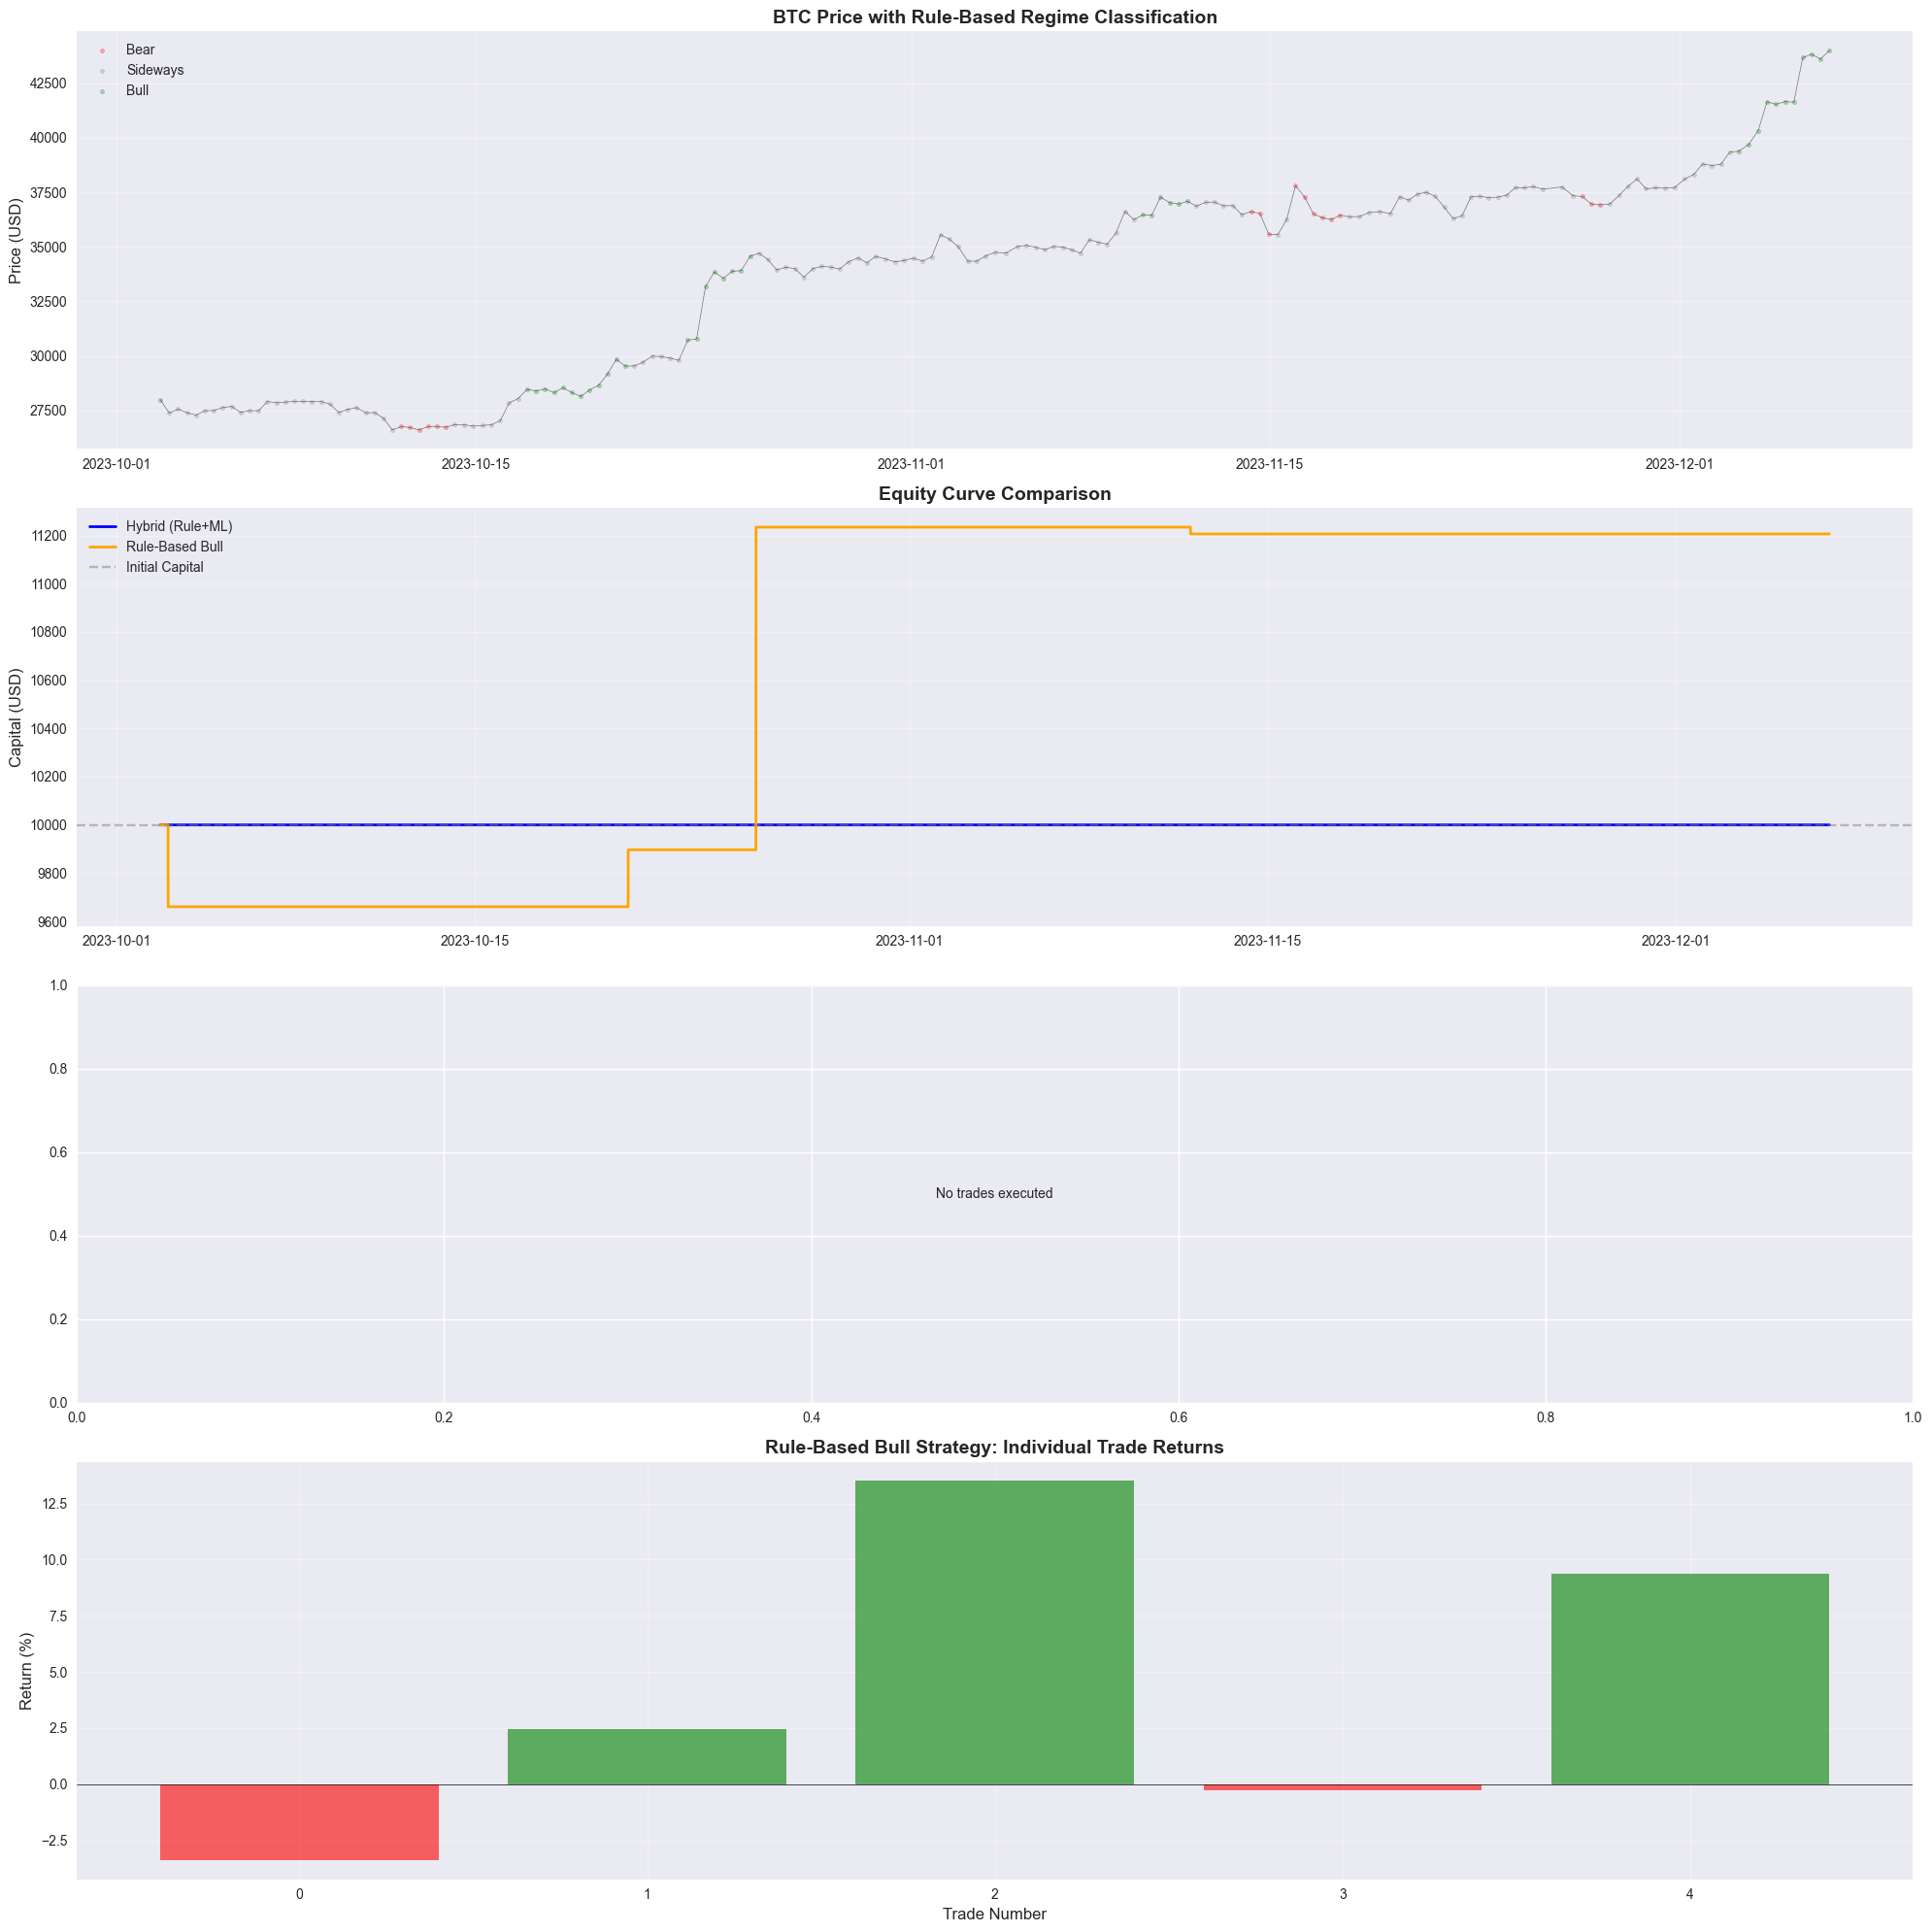


Visualization complete


In [40]:
# Visualization
fig, axes = plt.subplots(4, 1, figsize=(20, 20))

# Plot 1: Price with regime overlay
ax = axes[0]
sample_interval = 500
sample_data = df_backtest.iloc[::sample_interval]

regime_colors = {0: 'red', 1: 'gray', 2: 'green'}
for regime in [0, 1, 2]:
    mask = sample_data['regime'] == regime
    if mask.any():
        ax.scatter(sample_data.index[mask], sample_data['Close'][mask], 
                  c=regime_colors[regime], alpha=0.3, s=10, label=regime_names[regime])

ax.plot(sample_data.index, sample_data['Close'], 'k-', linewidth=0.5, alpha=0.5)
ax.set_title('BTC Price with Rule-Based Regime Classification', fontsize=14, fontweight='bold')
ax.set_ylabel('Price (USD)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Equity curves comparison
ax = axes[1]
ax.plot(df_backtest.index, hybrid_results['equity_curve'], label='Hybrid (Rule+ML)', linewidth=2, color='blue')
ax.plot(df_backtest.index, rulebased_results['equity_curve'], label='Rule-Based Bull', linewidth=2, color='orange')
ax.axhline(y=10000, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
ax.set_title('Equity Curve Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Capital (USD)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Trade analysis - Hybrid
ax = axes[2]
if hybrid_results['num_trades'] > 0:
    trades_df = pd.DataFrame(hybrid_results['trades'])
    colors = ['green' if x > 0 else 'red' for x in trades_df['return_pct']]
    ax.bar(range(len(trades_df)), trades_df['return_pct'], color=colors, alpha=0.6)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_title('Hybrid Strategy: Individual Trade Returns', fontsize=14, fontweight='bold')
    ax.set_xlabel('Trade Number', fontsize=12)
    ax.set_ylabel('Return (%)', fontsize=12)
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'No trades executed', ha='center', va='center', transform=ax.transAxes)

# Plot 4: Trade analysis - Rule-Based
ax = axes[3]
if rulebased_results['num_trades'] > 0:
    trades_df = pd.DataFrame(rulebased_results['trades'])
    colors = ['green' if x > 0 else 'red' for x in trades_df['return_pct']]
    ax.bar(range(len(trades_df)), trades_df['return_pct'], color=colors, alpha=0.6)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_title('Rule-Based Bull Strategy: Individual Trade Returns', fontsize=14, fontweight='bold')
    ax.set_xlabel('Trade Number', fontsize=12)
    ax.set_ylabel('Return (%)', fontsize=12)
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'No trades executed', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

print("\nVisualization complete")

## 10. Detailed Trade Log Analysis

In [41]:
print("="*70)
print("DETAILED TRADE LOGS")
print("="*70)

# Hybrid trades
print("\nHybrid Strategy (Rule-Based Regime + ML Signal):")
print("-" * 70)
if hybrid_results['num_trades'] > 0:
    hybrid_trades = pd.DataFrame(hybrid_results['trades'])
    hybrid_trades['duration'] = (hybrid_trades['exit_time'] - hybrid_trades['entry_time'])
    hybrid_trades['duration_hours'] = hybrid_trades['duration'].dt.total_seconds() / 3600
    
    for idx, trade in hybrid_trades.iterrows():
        print(f"\nTrade {idx+1}:")
        print(f"  Entry:  {trade['entry_time']} @ ${trade['entry_price']:.2f}")
        print(f"  Exit:   {trade['exit_time']} @ ${trade['exit_price']:.2f}")
        print(f"  Return: {trade['return_pct']:+.2f}%")
        print(f"  Duration: {trade['duration_hours']:.1f} hours")
        print(f"  Exit Reason: {trade['exit_reason']}")
else:
    print("No trades executed")

# Rule-based trades
print("\n" + "="*70)
print("Rule-Based Bull Strategy:")
print("-" * 70)
if rulebased_results['num_trades'] > 0:
    rb_trades = pd.DataFrame(rulebased_results['trades'])
    rb_trades['duration'] = (rb_trades['exit_time'] - rb_trades['entry_time'])
    rb_trades['duration_hours'] = rb_trades['duration'].dt.total_seconds() / 3600
    
    for idx, trade in rb_trades.iterrows():
        print(f"\nTrade {idx+1}:")
        print(f"  Entry:  {trade['entry_time']} @ ${trade['entry_price']:.2f}")
        print(f"  Exit:   {trade['exit_time']} @ ${trade['exit_price']:.2f}")
        print(f"  Return: {trade['return_pct']:+.2f}%")
        print(f"  Duration: {trade['duration_hours']:.1f} hours")
        print(f"  Exit Reason: {trade['exit_reason']}")
else:
    print("No trades executed")

DETAILED TRADE LOGS

Hybrid Strategy (Rule-Based Regime + ML Signal):
----------------------------------------------------------------------
No trades executed

Rule-Based Bull Strategy:
----------------------------------------------------------------------

Trade 1:
  Entry:  2023-10-02 16:40:00 @ $27996.70
  Exit:   2023-10-03 00:00:00 @ $27472.60
  Return: -3.39%
  Duration: 7.3 hours
  Exit Reason: Regime change: 2.0->1.0, P&L: -3.39%

Trade 2:
  Entry:  2023-10-17 00:00:00 @ $28492.20
  Exit:   2023-10-21 00:00:00 @ $29621.50
  Return: +2.44%
  Duration: 96.0 hours
  Exit Reason: Regime change: 2.0->1.0, P&L: 2.44%

Trade 3:
  Entry:  2023-10-23 00:00:00 @ $29947.80
  Exit:   2023-10-26 00:00:00 @ $34450.50
  Return: +13.52%
  Duration: 72.0 hours
  Exit Reason: Regime change: 2.0->1.0, P&L: 13.52%

Trade 4:
  Entry:  2023-11-10 00:00:00 @ $36636.40
  Exit:   2023-11-12 00:00:00 @ $37101.70
  Return: -0.25%
  Duration: 48.0 hours
  Exit Reason: Regime change: 2.0->1.0, P&L: -0.25%

## 11. Final Summary and Insights

In [42]:
print("\n" + "="*70)
print("FINAL SUMMARY: HYBRID RULE-ML STRATEGY")
print("="*70)

print("\nArchitecture:")
print("  Stage 1: Rule-Based Regime Detection (Daily momentum w/ MACD+FD)")
print("  Stage 2: ML Signal Generator (Entry timing within Bull regimes)")

print("\nKey Advantages:")
print("  1. Separates regime detection (rules) from timing (ML)")
print("  2. ML only focuses on pattern recognition, not regime classification")
print("  3. Rule-based regime provides stable, interpretable market context")
print("  4. ML optimizes entry timing within proven Bull regimes")

print("\nConfiguration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

print(f"\nML Model:")
print(f"  Best Model: {best_model_name}")
print(f"  Features: {len(selected_features)} (reduced from {len(feature_cols)})")
print(f"  Test AUC: {results[best_model_name]['test_auc']:.3f}")
print(f"  Test Accuracy: {results[best_model_name]['test_acc']:.1%}")

print(f"\nBacktest Results:")
print(f"  Hybrid Strategy: {hybrid_results['total_return']:+.2f}% ({hybrid_results['num_trades']} trades)")
print(f"  Rule-Based Bull: {rulebased_results['total_return']:+.2f}% ({rulebased_results['num_trades']} trades)")

if hybrid_results['total_return'] > rulebased_results['total_return']:
    print(f"\nConclusion: ML timing adds value (+{hybrid_results['total_return'] - rulebased_results['total_return']:.2f}%)")
    print("  The hybrid approach successfully optimizes entry timing within Bull regimes.")
elif rulebased_results['total_return'] > hybrid_results['total_return']:
    print(f"\nConclusion: Simple rule-based performs better (+{rulebased_results['total_return'] - hybrid_results['total_return']:.2f}%)")
    print("  Consider: ML may be overfitting or adding unnecessary complexity.")
    print("  Next steps: Review ML features, adjust parameters, or use simpler entry rules.")
else:
    print(f"\nConclusion: Strategies perform equally well")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)


FINAL SUMMARY: HYBRID RULE-ML STRATEGY

Architecture:
  Stage 1: Rule-Based Regime Detection (Daily momentum w/ MACD+FD)
  Stage 2: ML Signal Generator (Entry timing within Bull regimes)

Key Advantages:
  1. Separates regime detection (rules) from timing (ML)
  2. ML only focuses on pattern recognition, not regime classification
  3. Rule-based regime provides stable, interpretable market context
  4. ML optimizes entry timing within proven Bull regimes

Configuration:
  price_rise_threshold: 0.04
  stop_loss_pct: 0.04
  lookforward_hours: 24
  commission: 0.0075
  regime_timeframe: 1D
  train_test_split: 0.7
  ml_entry_threshold: 0.3

ML Model:
  Best Model: Logistic Regression
  Features: 16 (reduced from 17)


KeyError: 'Logistic Regression'